## One code skeleton, three PDEs

Here’s a **single “mini FEM engine”** for 1D linear elements where the *only thing that changes* between Poisson, diffusion, and wave is which **weak-form terms** you include:

* **stiffness** term: (\int k,u_x v_x,dx)  → matrix **K**
* **mass** term: (\int \rho c,u,v,dx) (or (\int \frac{1}{c^2}u,v,dx)) → matrix **M**
* **source** term: (\int f,v,dx) → vector **F**

Everything else (mesh, basis, quadrature, assembly, BC enforcement) is identical.

### What to notice (the “generic” part)

### 1) The **assembly function** never changes

`assemble_1d_linear()` is the generic engine:

* basis functions + quadrature + scatter-add
* it can build **K**, **M**, **F** for *any* PDE whose weak form uses those standard integrals.

### 2) Each PDE is just “choose which terms exist”

* **Poisson:** use **K** and **F** → `K u = F`
* **Diffusion:** use **M, K, F** → `M u_t + K u = F`
* **Wave:** use **M, K, F** → `M u_tt + K u = F`

So the *physics* changes, but the *machinery* is identical.

### 3) “Formulate once per PDE class”

You do need the weak form once per PDE class (elliptic/parabolic/hyperbolic, elasticity, etc.), but you do **not** do element algebra by hand once you have:

* a small library of operators (mass, stiffness, advection, divergence, curl, etc.)
* plus a generic assembler.

That’s exactly what large FEM frameworks are: “weak-form operator libraries + assembly + solvers.”



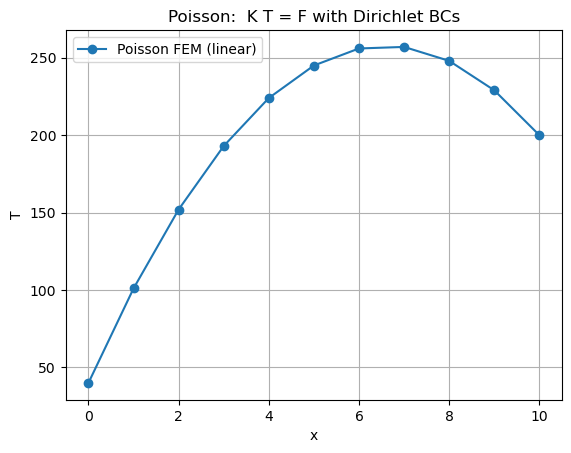

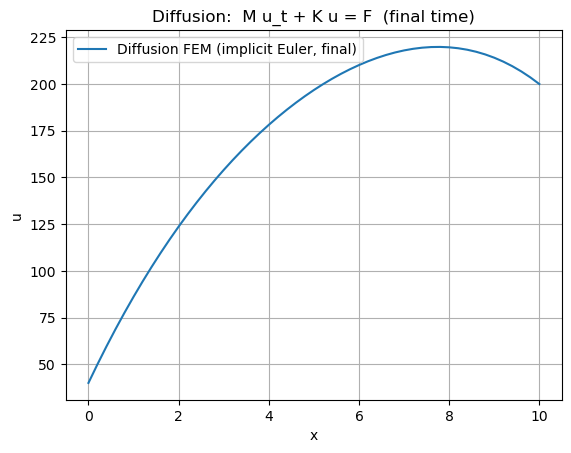

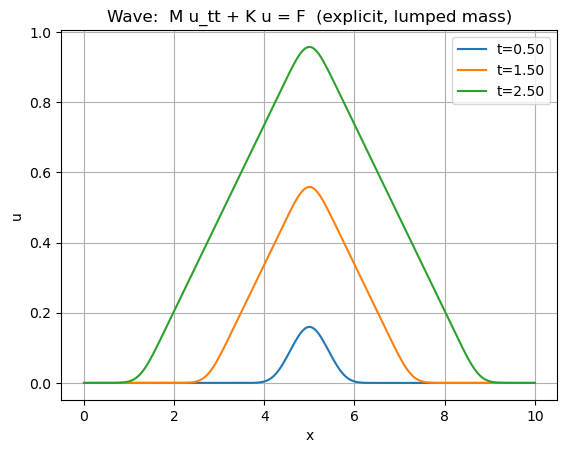

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Generic 1D linear FEM building blocks
# -----------------------------

def assemble_1d_linear(nel, L, k_fun=None, m_fun=None, f_fun=None):
    """
    Assemble global stiffness K, mass M, load F for 1D linear elements on [0,L].

    Weak-form templates:
      K_ij += ∫ k(x) dNi/dx dNj/dx dx
      M_ij += ∫ m(x) Ni Nj dx
      F_i  += ∫ f(x) Ni dx

    We use 2-point Gauss quadrature on each element.
    """
    nn = nel + 1
    x = np.linspace(0.0, L, nn)
    K = np.zeros((nn, nn))
    M = np.zeros((nn, nn))
    F = np.zeros(nn)

    # Reference element [-1,1] Gauss points
    gp = np.array([-1.0/np.sqrt(3.0), +1.0/np.sqrt(3.0)])
    gw = np.array([1.0, 1.0])

    for e in range(nel):
        i, j = e, e+1
        x1, x2 = x[i], x[j]
        h = x2 - x1
        J = h / 2.0  # dx = J dxi

        # Linear shape functions on reference element:
        # N1 = (1-xi)/2, N2 = (1+xi)/2
        # dN/dx = dN/dxi * dxi/dx = dN/dxi * (2/h)
        dN_dxi = np.array([-0.5, +0.5])
        dN_dx  = dN_dxi * (2.0/h)

        Ke = np.zeros((2,2))
        Me = np.zeros((2,2))
        Fe = np.zeros(2)

        for xi, w in zip(gp, gw):
            N = np.array([(1.0 - xi)/2.0, (1.0 + xi)/2.0])
            xq = (x1 + x2)/2.0 + xi * J  # map to physical

            kq = k_fun(xq) if k_fun is not None else 0.0
            mq = m_fun(xq) if m_fun is not None else 0.0
            fq = f_fun(xq) if f_fun is not None else 0.0

            # K contribution: k * (dN/dx)^T (dN/dx)
            Ke += kq * np.outer(dN_dx, dN_dx) * (w * J)

            # M contribution: m * N^T N
            Me += mq * np.outer(N, N) * (w * J)

            # F contribution: f * N
            Fe += fq * N * (w * J)

        # Scatter add
        idx = [i, j]
        for a in range(2):
            A = idx[a]
            F[A] += Fe[a]
            for b in range(2):
                B = idx[b]
                K[A,B] += Ke[a,b]
                M[A,B] += Me[a,b]

    return x, K, M, F


def apply_dirichlet_direct(A, b, bc):
    """
    Direct (elimination/substitution) Dirichlet BCs.
    bc is dict: node_index -> value
    Returns modified copies.
    """
    A = A.copy()
    b = b.copy()
    n = len(b)
    for k, val in bc.items():
        # subtract column contribution from RHS
        for i in range(n):
            b[i] -= A[i, k] * val
            if i != k:
                A[i, k] = 0.0
        # enforce equation u_k = val
        A[k, :] = 0.0
        A[k, k] = 1.0
        b[k] = val
    return A, b


def lump_mass(M):
    """Diagonal mass lumping (useful for explicit wave)."""
    return np.diag(np.sum(M, axis=1))


# -----------------------------
# PDE 1: Poisson  - (k u_x)_x = f
# -----------------------------
def solve_poisson():
    L = 10.0
    nel = 10
    T0, TL = 40.0, 200.0
    f_val = 10.0

    # For T'' = -10, the weak form is ∫ T_x v_x = ∫ f v with f=10 and k=1
    x, K, M, F = assemble_1d_linear(
        nel, L,
        k_fun=lambda x: 1.0,
        m_fun=None,
        f_fun=lambda x: f_val
    )

    # Apply Dirichlet BCs on K T = F
    bc = {0: T0, len(x)-1: TL}
    Kb, Fb = apply_dirichlet_direct(K, F, bc)
    T = np.linalg.solve(Kb, Fb)
    return x, T


# -----------------------------
# PDE 2: Diffusion  m u_t - (k u_x)_x = f
# Semi-discrete: M u_dot + K u = F
# Time step: implicit Euler
# -----------------------------
def solve_diffusion():
    L = 10.0
    nel = 50
    T0, TL = 40.0, 200.0
    f_val = 10.0

    k = 1.0
    m = 1.0  # "capacity" term

    x, K, M, F = assemble_1d_linear(
        nel, L,
        k_fun=lambda x: k,
        m_fun=lambda x: m,
        f_fun=lambda x: f_val
    )

    bc = {0: T0, len(x)-1: TL}

    # initial condition (e.g., linear between BCs)
    u = np.linspace(T0, TL, len(x))

    dt = 0.05
    nt = 200

    # Implicit Euler: (M/dt + K) u^{n+1} = F + M/dt * u^n
    A = M/dt + K

    for _ in range(nt):
        rhs = F + (M/dt) @ u
        Ab, rhsb = apply_dirichlet_direct(A, rhs, bc)
        u = np.linalg.solve(Ab, rhsb)

    return x, u


# -----------------------------
# PDE 3: Wave  m u_tt + K u = F
# Semi-discrete: M u_ddot + K u = F
# Time step: explicit central difference with lumped mass
# -----------------------------
def solve_wave():
    L = 10.0
    nel = 200

    c = 1.5      # wave speed
    m = 1.0/(c*c)  # for (1/c^2) u_tt - u_xx = s  => M uses 1/c^2

    # source: a localized bump
    def s_fun(x):
        return np.exp(-((x-5.0)/0.3)**2)

    x, K, M, F = assemble_1d_linear(
        nel, L,
        k_fun=lambda x: 1.0,
        m_fun=lambda x: m,
        f_fun=lambda x: s_fun(x)
    )

    # Homogeneous Dirichlet ends (fixed)
    bc = {0: 0.0, len(x)-1: 0.0}

    # Lump mass for explicit update
    Ml = lump_mass(M)
    Minv = 1.0/np.diag(Ml)

    # Time stepping
    dx = x[1]-x[0]
    dt = 0.4 * dx / c  # simple CFL-ish choice for 1D
    nt = 800

    u_nm1 = np.zeros_like(x)  # u^{n-1}
    u_n   = np.zeros_like(x)  # u^{n}
    # initial velocity = 0, so u^{1} can be formed using u_tt at n=0
    # but we’ll just start with zeros and let source drive.

    snapshots = []
    snap_times = [0.5, 1.5, 2.5]
    t = 0.0

    for it in range(nt):
        # acceleration: u_tt = M^{-1}(F - K u)
        a = Minv * (F - K @ u_n)

        # central difference: u^{n+1} = 2u^n - u^{n-1} + dt^2 a
        u_np1 = 2.0*u_n - u_nm1 + (dt*dt)*a

        # enforce BCs directly on state (strong)
        u_np1[0] = 0.0
        u_np1[-1] = 0.0

        t += dt
        # store a few snapshots
        for st in snap_times:
            if (t-dt) < st <= t:
                snapshots.append((st, u_np1.copy()))

        u_nm1, u_n = u_n, u_np1

    return x, snapshots


# -----------------------------
# Run and plot all three
# -----------------------------
xP, TP = solve_poisson()

plt.figure()
plt.plot(xP, TP, "-o", label="Poisson FEM (linear)")
plt.xlabel("x"); plt.ylabel("T"); plt.grid(True); plt.legend()
plt.title("Poisson:  K T = F with Dirichlet BCs")
plt.show()

xD, uD = solve_diffusion()
plt.figure()
plt.plot(xD, uD, label="Diffusion FEM (implicit Euler, final)")
plt.xlabel("x"); plt.ylabel("u"); plt.grid(True); plt.legend()
plt.title("Diffusion:  M u_t + K u = F  (final time)")
plt.show()

xW, snaps = solve_wave()
plt.figure()
for t, u in snaps:
    plt.plot(xW, u, label=f"t={t:.2f}")
plt.xlabel("x"); plt.ylabel("u"); plt.grid(True); plt.legend()
plt.title("Wave:  M u_tt + K u = F  (explicit, lumped mass)")
plt.show()
